In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

In [139]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [183]:
#from sklearn.datasets import fetch_openml

#mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

images_all = np.append(train_images, test_images, axis=0)
print(images_all)

labels_all = np.append(train_labels, test_labels, axis=0)
print(labels_all)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[5 0 4 ... 4 5 6]


In [184]:
X = images_all.astype("float32") # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range
X = X.reshape(len(X), 1, 28, 28)  # reshape into [N, C, H, W] for PyTorch

y = labels_all.astype("int64")  # 1D array of labels

In [185]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [186]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

In [187]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 10  # 3 for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6207       0.9333        0.2430  7.8828
      2        0.1694       0.9539        0.1576  7.4871
      3        0.1209       0.9632        0.1258  7.6632
      4        0.0989       0.9672        0.1085  7.6144
      5        0.0856       0.9696        0.0977  7.5383
      6        0.0763       0.9718        0.0887  7.5610
      7        0.0693       0.9745        0.0827  7.5220
      8        0.0637       0.9756        0.0778  7.7410
      9        0.0592       0.9764        0.0737  7.6226
     10        0.0553       0.9775        0.0703  7.7046
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6614       0.9340        0.2412  7.6391
      2        0.1778       0.9573        0.1488  7.7627
      3        0.1237       0.9663        0.1169  7.6819
      4        0.1004       0.9

      7        0.0627       0.9770        0.0756  7.7268
      8        0.0574       0.9779        0.0717  7.9589
      9        0.0531       0.9788        0.0684  7.8174
     10        0.0495       0.9796        0.0660  7.4788
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6936       0.9328        0.2568  7.6108
      2        0.1940       0.9580        0.1567  7.6682
      3        0.1301       0.9663        0.1217  7.8416
      4        0.1031       0.9706        0.1037  7.6649
      5        0.0880       0.9732        0.0929  7.7557
      6        0.0780       0.9755        0.0854  7.6986
      7        0.0707       0.9767        0.0801  7.9307
      8        0.0651       0.9779        0.0760  7.7441
      9        0.0605       0.9786        0.0725  7.7465
     10        0.0567       0.9798        0.0696  7.9535


In [188]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9791285714285715


In [199]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Most likely label errors: \n {ranked_label_issues}")

Cleanlab found 122 label issues.
Most likely label errors: 
 [59915 24798 31134 59701 53216 50340 42566 10994  7010 49543 65955 23824
  8729 32776 31596  2720 61014  4476 36238 25829 69729  1604 44848 14582
   995 16676 42973  6448 17551 25678   494 26471 27522 26560   500 39656
   854 20672 28556 44456 46288 51248 43109 46269 43454 57764 21348 31428
 14008 41396 46435 20773 50514 13136 37734 60947 64956 12559  6848 25262
 33768 61681 34750 34404 52218  6658 34678 26629 69009 19124 26626 35234
 22779 31198 34048  1244 26444  5554 11570 28688 62130 57662 10116 47918
 20735 50239 62896 49006 35616 47421 45761 54074 31284 20072 27225 26504
 10241  8449  7080 24938 50329 47152 39184  8709 27155 27846 53156 47008
 47227 44850 41284 47094 10064 41594 14740 56480 69893 11885 51944 26749
 41464 26394]


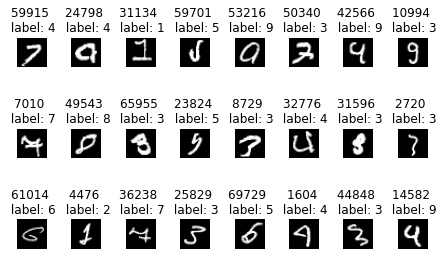

In [200]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"{id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0, w_pad=2.5)
    
plot_examples(ranked_label_issues[range(24)], 3, 8)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images_all[10994])


In [ ]:
print(labels_all[10994])